n :  3
Alphas for n =  3  :  [0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9]
Probabilities for n =  3  :  [0.4735, 0.6089, 0.7456, 0.864, 0.9419, 0.9711, 0.977, 0.9773, 0.9773, 0.9773]
n :  4
Alphas for n =  4  :  [0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9]
Probabilities for n =  4  :  [0.5058, 0.6329, 0.7611, 0.8718, 0.9478, 0.9861, 0.9974, 0.9979, 0.9979, 0.9979]
n :  5
Alphas for n =  5  :  [0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9]
Probabilities for n =  5  :  [0.5358, 0.6732, 0.8048, 0.9108, 0.9696, 0.9916, 0.9985, 0.9997, 0.9997, 0.9998]


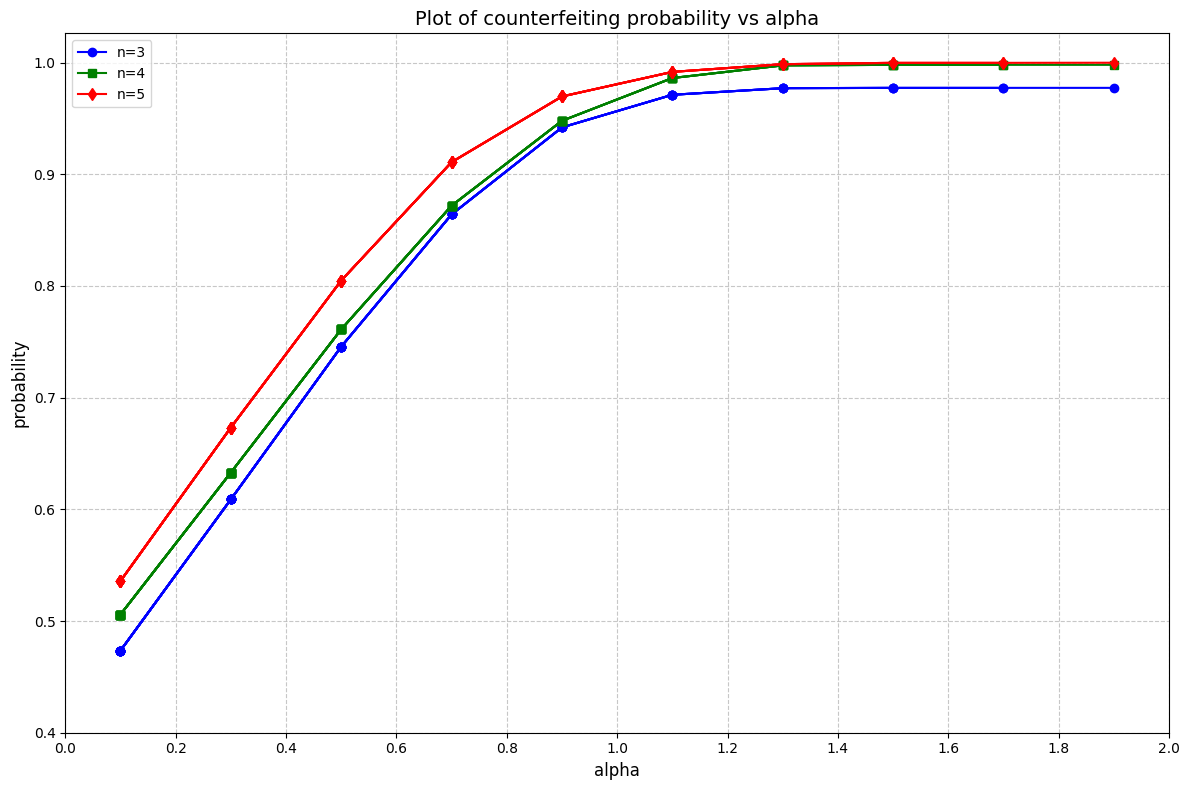

In [23]:
import numpy as np
import math
import sympy as sp
import cvxpy as cp
import matplotlib.pyplot as plt

def Calculate_Hermite_polynomial(n):
    hermite_polynomial = 0
    sum_limit = math.floor(n/2)
    #We don't want to use evaluate the polynomial with a numerical value of x, that's why we use a symbolic 'x' from sympy library
    x = sp.symbols('x')
    for m in range(0,sum_limit+1):
        #Since we are using symbolic value 'x', we are using a Pow function from sympy library
        hermite_increment = math.factorial(n) * (math.pow(-1,m)*sp.Pow((2*x),(n-2*m))/(math.factorial(m)*math.factorial(n-2*m)))
        hermite_polynomial += hermite_increment
    return hermite_polynomial

def Calculate_weighted_integral_for_hermite_0_1(n,m):
    #This function will be used to calculate the projector 0 and 1, it evaluate the integral from 0 to infinity
    x = sp.symbols('x')
    Hermite_polynomial_values = Calculate_Hermite_polynomial(n)*Calculate_Hermite_polynomial(m)*sp.exp(-sp.Pow(x,2))
    # sp.oo represent  infinity
    Hermite_polynomial_integral = sp.integrate(Hermite_polynomial_values, (x, 0, sp.oo))
    algebraic_part = 1/math.sqrt(math.pow(2,n+m)*math.factorial(n)*math.factorial(m)*math.pi)
    weighted_integral = algebraic_part * Hermite_polynomial_integral
    return weighted_integral
    
    
def Calculate_weighted_integral_for_hermite_2_3(n,m):
    #This function will be used to calculate the projector 2 and 3, it evaluate the integral from -infinity to 0
    x = sp.symbols('x')
    Hermite_polynomial_values = Calculate_Hermite_polynomial(n)*Calculate_Hermite_polynomial(m)*sp.exp(-sp.Pow(x,2))
    # sp.oo represent  infinity
    Hermite_polynomial_integral = sp.integrate(Hermite_polynomial_values, (x, -sp.oo , 0))
    algebraic_part = 1/math.sqrt(math.pow(2,n+m)*math.factorial(n)*math.factorial(m)*math.pi)
    weighted_integral = algebraic_part * Hermite_polynomial_integral
    return weighted_integral

## Potential error
def Generate_projector_0(n):
    projector = np.zeros((n,n), dtype=np.complex128)
    for i in range(n):
        for j in range(n):
            projector[i,j] = Calculate_weighted_integral_for_hermite_0_1(i,j)
    return projector


def Generate_projector_1(n):
    projector = np.zeros((n,n), dtype=complex)
    for i in range(0,n):
        for j in range(0,n):
            projector[i,j] = sp.Pow(sp.I,j-1)*sp.Pow(-sp.I,i-1)* Calculate_weighted_integral_for_hermite_0_1(i,j)
    return projector

def Generate_projector_2(n):
    projector = np.zeros((n,n), dtype=complex)
    for i in range(0,n):
        for j in range(0,n):
            projector[i,j] = Calculate_weighted_integral_for_hermite_2_3(i,j)

    return projector


def Generate_projector_3(n):
    projector = np.zeros((n,n), dtype=complex)
    for i in range(0,n):
        for j in range(0,n):
            projector[i,j] = sp.Pow(sp.I,j-1)*sp.Pow(-sp.I,i-1)* Calculate_weighted_integral_for_hermite_2_3(i,j)
    return projector

def partial_trace_cvxpy(rho, dims, axis=0):
    """CVXPY-compatible partial trace implementation"""
    d1, d2 = dims
    if axis == 0:
        # Tracing out the first subsystem
        result = cp.Constant(np.zeros((d2, d2), dtype=complex))
        for i in range(d1):
            # Slice the appropriate blocks
            start = i*d2
            end = (i+1)*d2
            block = rho[start:end, start:end]
            result += block
    else:
        # Tracing out the second subsystem
        result = cp.Constant(np.zeros((d1, d1), dtype=complex))
        for i in range(d2):
            # Slice the diagonal blocks
            block = rho[i::d2, i::d2]
            result += block[0:d1, 0:d1]
    return result
    
plt.figure(figsize=(12, 8))

for n in range(3,6):
    print("n : ", n)
    #Building Measurements projectors
    Measurement_projector_0 = Generate_projector_0(n)
    Measurement_projector_1 = Generate_projector_1(n)
    Measurement_projector_2 = Generate_projector_2(n)
    Measurement_projector_3 = Generate_projector_3(n)

    # #Applying tensor product
    Measurement_projector_00 = np.kron(Measurement_projector_0,Measurement_projector_0)
    Measurement_projector_11 = np.kron(Measurement_projector_1,Measurement_projector_1)
    Measurement_projector_22 = np.kron(Measurement_projector_2,Measurement_projector_2)
    Measurement_projector_33 = np.kron(Measurement_projector_3,Measurement_projector_3)
    
    #Preparing fock state bra
    fock_state_bra_0 = np.array([1,0,0,0], dtype=complex)
    fock_state_bra_1 = np.array([0,1,0,0], dtype=complex)
    fock_state_bra_2 = np.array([0,0,1,0], dtype=complex)
    fock_state_bra_3 = np.array([0,0,0,1], dtype=complex)

    #Preparing fock state ket
    fock_state_ket_0 = fock_state_bra_0.reshape(-1, 1)
    fock_state_ket_1 = fock_state_bra_1.reshape(-1, 1)
    fock_state_ket_2 = fock_state_bra_2.reshape(-1, 1)
    fock_state_ket_3 = fock_state_bra_3.reshape(-1, 1)

    #Preparing density matrices (ket * bra)
    coherent_state_density_0 = fock_state_ket_0 * fock_state_bra_0
    coherent_state_density_1 = fock_state_ket_1 * fock_state_bra_1 
    coherent_state_density_2 = fock_state_ket_2 * fock_state_bra_2 
    coherent_state_density_3 = fock_state_ket_3 * fock_state_bra_3 

    #### Plot Preperation
    alphas = []
    probabilities = []
    colors = ['b', 'g','r']  # Different colors for each n
    markers = ['o', 's','d']  # Different colors for each n
    printed = False #Legend Plotting flag
    #### End of Plot preperation
    
    for c in range(0,10):
        m = 0.1 + c * 0.2
        alpha = m
        #Adding alphas value for plotting:
        rounded_alpha = round(alpha, 1)
        alphas.append(rounded_alpha)

        #Coefficients creation
        C0 = (math.exp(-(pow(alpha,2))/2)/math.sqrt(2)) * math.sqrt(math.cosh(pow(alpha,2))+ math.cos(pow(alpha,2)))
        C2 = (math.exp(-(pow(alpha,2))/2)/math.sqrt(2)) * math.sqrt(math.cosh(pow(alpha,2))- math.cos(pow(alpha,2)))
        C1 = (math.exp(-(pow(alpha,2))/2)/math.sqrt(2)) * math.sqrt(math.sinh(pow(alpha,2))+ math.sin(pow(alpha,2)))
        C3 = (math.exp(-(pow(alpha,2))/2)/math.sqrt(2)) * math.sqrt(math.sinh(pow(alpha,2))- math.sin(pow(alpha,2)))
       
        #Coherent State Kets
        coherent_state_ket_0 = C0*fock_state_ket_0 + C1*fock_state_ket_1 + C2*fock_state_ket_2 + C3*fock_state_ket_3
        coherent_state_ket_1 = C0*fock_state_ket_0 + sp.I*C1*fock_state_ket_1 - C2*fock_state_ket_2 - sp.I* C3*fock_state_ket_3
        coherent_state_ket_2 = C0*fock_state_ket_0 - C1*fock_state_ket_1 + C2*fock_state_ket_2 - C3*fock_state_ket_3
        coherent_state_ket_3 = C0*fock_state_ket_0 - sp.I*C1*fock_state_ket_1 - C2*fock_state_ket_2 + sp.I*C3*fock_state_ket_3
        
        # Coherent State Bra Complex Transpose
        coherent_state_bra_0 = coherent_state_ket_0.conj().T
        coherent_state_bra_1 = coherent_state_ket_1.conj().T
        coherent_state_bra_2 = coherent_state_ket_2.conj().T
        coherent_state_bra_3 = coherent_state_ket_3.conj().T

        # Coherent states density matrices
        coherent_state_density_0 = coherent_state_ket_0 * coherent_state_bra_0
        coherent_state_density_1 = coherent_state_ket_1 * coherent_state_bra_1
        coherent_state_density_2= coherent_state_ket_2 * coherent_state_bra_2
        coherent_state_density_3 = coherent_state_ket_3 * coherent_state_bra_3

        Q = 1/4*(np.kron(coherent_state_density_0,Measurement_projector_00) + np.kron(coherent_state_density_1,Measurement_projector_11) + np.kron(coherent_state_density_2,Measurement_projector_22) + np.kron(coherent_state_density_3,Measurement_projector_33))
        
        Q = np.array(Q, dtype=np.complex128)
        Q_cvx = cp.Constant(Q)
        X = cp.Variable((4 * n**2, 4 * n**2), complex=True)
        
        objective = cp.Maximize(cp.trace(cp.real(Q_cvx @ X)))

        constraints = [
            partial_trace_cvxpy(X, dims=[4, n**2], axis=1) == np.eye(4),
            X >> 0
        ]

        problem = cp.Problem(objective, constraints)
        problem.solve(solver='SCS')
        prob = problem.value
        rounded_prob = round(prob, 4)
        probabilities.append(rounded_prob)
        #### All the below is for Plotting only and its not related to the optimzation problem
        if(printed == False):
            plt.plot(alphas, probabilities, marker=markers[n % len(markers)], linestyle='-', color=colors[n % len(colors)],label=f'n={n}')  # Use 'i' for color indexing
        else:
            plt.plot(alphas, probabilities, marker=markers[n % len(markers)], linestyle='-', color=colors[n % len(colors)])#,label=f'n={n}')  # Use 'i' for color indexing
        printed = True
    print("Alphas for n = ", n ," : ",alphas)
    print("Probabilities for n = ", n ," : ",probabilities)


# Configuring plot
plt.xlabel("alpha", fontsize=12)
plt.ylabel("probability", fontsize=12)
plt.xticks(np.arange(0, 2.1, 0.2))
plt.yticks(np.arange(0.4, 1.1, 0.1))
plt.title("Plot of counterfeiting probability vs alpha", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()   